# VLB Flow Curve: NLSQ → NUTS

**Ethyl cellulose 7 wt% solution — steady-state flow curve**

## Learning Objectives

- Fit a Newtonian flow curve to extract η₀ = G₀/k_d
- Understand parameter identifiability: only the ratio G₀/k_d is determined
- Run NLSQ → NUTS pipeline and observe the correlated posterior
- Discuss limitations of VLB for shear-thinning fluids

## Data Source

Ethyl cellulose solution flow curve from pyRheo demo datasets.
European CSV format (semicolons, comma decimals).

## Estimated Runtime

- Fast demo (1 chain): ~1 min
- Full run (4 chains): ~3 min

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax openpyxl
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import time
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import VLBLocal

jax, jnp = safe_import_jax()
verify_float64()
warnings.filterwarnings('ignore', category=FutureWarning)

# Tutorial utilities
import sys

sys.path.insert(0, str(Path('..').resolve()))
from utils.vlb_tutorial_utils import (
    get_bayesian_config,
    get_output_dir,
    load_ec_flow_curve,
    plot_trace_and_forest,
    print_convergence,
    print_parameter_table,
    save_figure,
    save_results,
)

print(f"JAX version: {jax.__version__}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX version: 0.8.3


## 2. Load Experimental Data

Data points: 43
Shear rate range: 0.100 - 1000 1/s
Viscosity range: 0.869 - 4.310 Pa-s


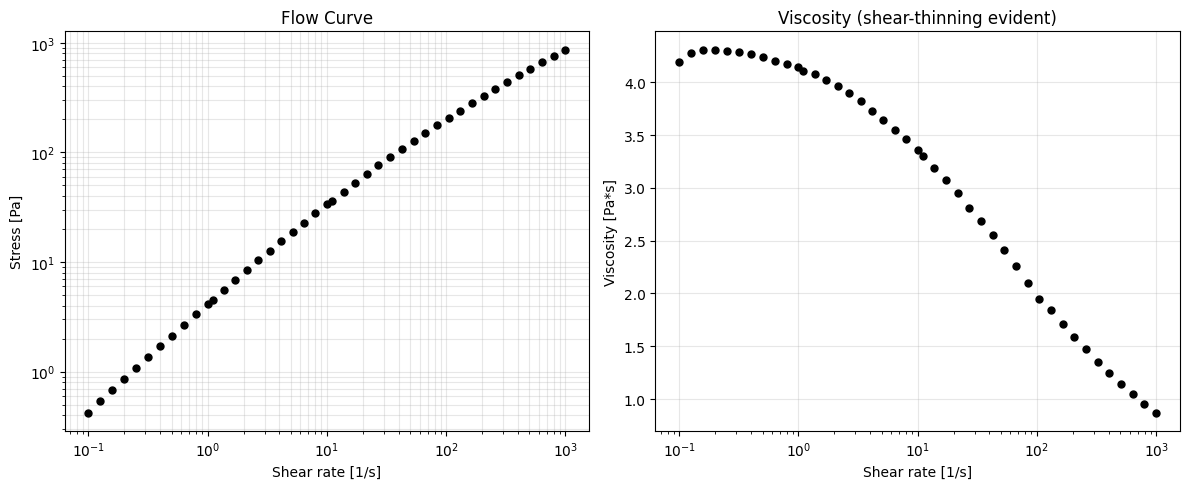

In [3]:
gamma_dot, stress, viscosity = load_ec_flow_curve('07-00')

print(f'Data points: {len(gamma_dot)}')
print(f'Shear rate range: {gamma_dot.min():.3f} - {gamma_dot.max():.0f} 1/s')
print(f'Viscosity range: {viscosity.min():.3f} - {viscosity.max():.3f} Pa-s')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.loglog(gamma_dot, stress, 'ko', markersize=5)
ax1.set_xlabel('Shear rate [1/s]')
ax1.set_ylabel('Stress [Pa]')
ax1.set_title('Flow Curve')
ax1.grid(True, alpha=0.3, which='both')

ax2.semilogx(gamma_dot, viscosity, 'ko', markersize=5)
ax2.set_xlabel('Shear rate [1/s]')
ax2.set_ylabel('Viscosity [Pa*s]')
ax2.set_title('Viscosity (shear-thinning evident)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 3. VLB Forward Model

VLB with constant $k_d$ predicts a **Newtonian** flow curve:

$$\sigma_{12} = \frac{G_0}{k_d} \dot{\gamma} = \eta_0 \dot{\gamma}$$

This is a limitation: VLB cannot capture shear-thinning without
a force-dependent $k_d$ (Bell model extension, see Notebook 08).
The fit will find the best constant viscosity $\eta_0$ for this data.

In [4]:
# Demonstrate forward prediction with trial parameters
model = VLBLocal()
model.parameters.set_value('G0', 10.0)
model.parameters.set_value('k_d', 5.0)

gamma_dot_fine = np.logspace(
    np.log10(gamma_dot.min()) - 0.3,
    np.log10(gamma_dot.max()) + 0.3, 200
)
stress_trial = model.predict(gamma_dot_fine, test_mode='flow_curve')

print(f'Trial: G0={model.G0}, k_d={model.k_d}, eta_0={model.G0/model.k_d:.2f} Pa*s')
print(f'VLB always predicts linear stress vs shear rate (Newtonian).')

Trial: G0=10.0, k_d=5.0, eta_0=2.00 Pa*s
VLB always predicts linear stress vs shear rate (Newtonian).


## 4. Step 1: NLSQ Point Estimation

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.752924s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=5 | final_cost=5.4951 | elapsed=0.753s | final_gradient_norm=0.2126


NLSQ fit time: 0.96 s
G0  = 4.19 Pa
k_d = 2.3258 1/s
eta_0 = G0/k_d = 1.802 Pa*s
R-squared = 0.1869


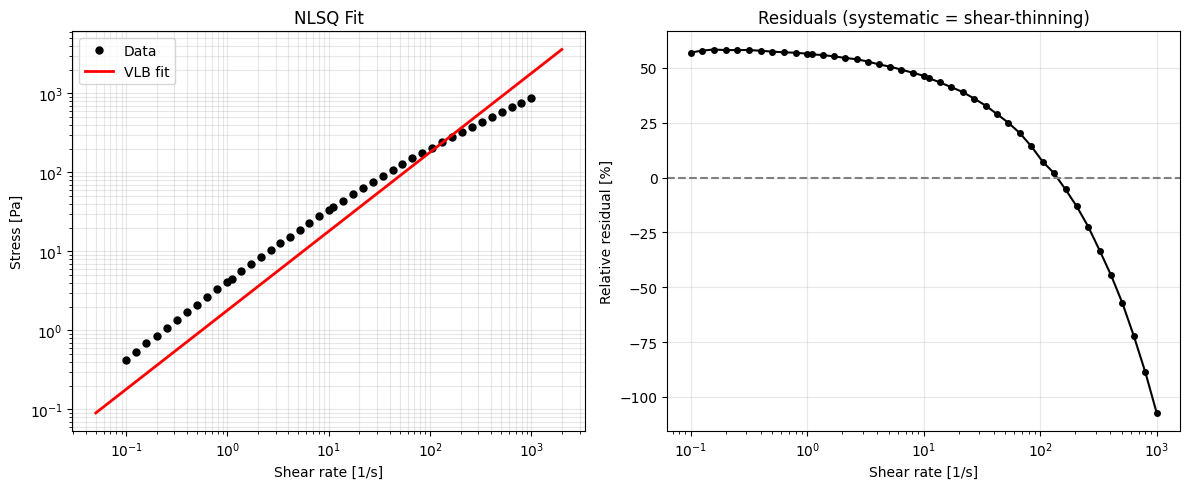

In [5]:
model = VLBLocal()

t0 = time.time()
model.fit(gamma_dot, stress, test_mode='flow_curve')
t_nlsq = time.time() - t0

print(f'NLSQ fit time: {t_nlsq:.2f} s')
print(f'G0  = {model.G0:.2f} Pa')
print(f'k_d = {model.k_d:.4f} 1/s')
print(f'eta_0 = G0/k_d = {model.G0 / model.k_d:.3f} Pa*s')

# Fit quality
stress_pred = model.predict(gamma_dot, test_mode='flow_curve')
ss_res = np.sum((np.array(stress) - np.array(stress_pred))**2)
ss_tot = np.sum((np.array(stress) - np.mean(stress))**2)
r2 = 1 - ss_res / ss_tot
print(f'R-squared = {r2:.4f}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.loglog(gamma_dot, stress, 'ko', markersize=5, label='Data')
ax1.loglog(gamma_dot_fine, model.predict(gamma_dot_fine, test_mode='flow_curve'),
           'r-', lw=2, label='VLB fit')
ax1.set_xlabel('Shear rate [1/s]')
ax1.set_ylabel('Stress [Pa]')
ax1.set_title('NLSQ Fit')
ax1.legend()
ax1.grid(True, alpha=0.3, which='both')

residuals = (np.array(stress) - np.array(stress_pred)) / np.array(stress) * 100
ax2.semilogx(gamma_dot, residuals, 'ko-', markersize=4)
ax2.axhline(0, color='gray', ls='--')
ax2.set_xlabel('Shear rate [1/s]')
ax2.set_ylabel('Relative residual [%]')
ax2.set_title('Residuals (systematic = shear-thinning)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Step 2: Bayesian Inference (NUTS)

**Note on identifiability:** The flow curve determines only $\eta_0 = G_0/k_d$.
The posterior will show a strong **correlation** between $G_0$ and $k_d$ —
this is expected and illustrates the importance of protocol choice.

In [6]:
config = get_bayesian_config()
initial_values = {'G0': float(model.G0), 'k_d': float(model.k_d)}
print(f'Config: {config}')
print(f'Warm-start: {initial_values}')

t0 = time.time()
result = model.fit_bayesian(
    gamma_dot, stress, test_mode='flow_curve',
    initial_values=initial_values,
    seed=42,
    **config,
)
t_bayes = time.time() - t0
print(f'\nBayesian inference time: {t_bayes:.1f} s')

Config: {'num_warmup': 50, 'num_samples': 100, 'num_chains': 1}
Warm-start: {'G0': 4.189995770787866, 'k_d': 2.325770323320096}


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:00<01:17,  1.93it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

sample: 100%|██████████| 150/150 [00:00<00:00, 262.91it/s, 215 steps of size 4.45e-03. acc. prob=0.97]


Bayesian inference time: 2.4 s


## 5. Convergence Diagnostics

In [7]:
param_names = ["G0", "k_d"]
converged = print_convergence(result, param_names)

Convergence Diagnostics
 Parameter     R-hat       ESS
--------------------------------------------------
        G0    1.1168        12 *
       k_d    1.1276        12 *

Divergences: 0
Convergence: CHECK REQUIRED


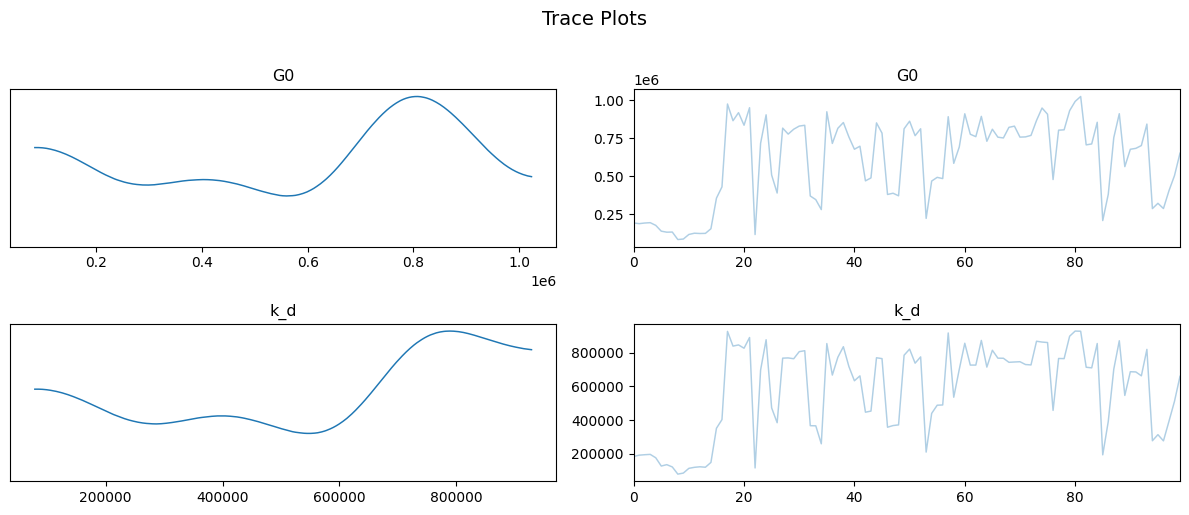

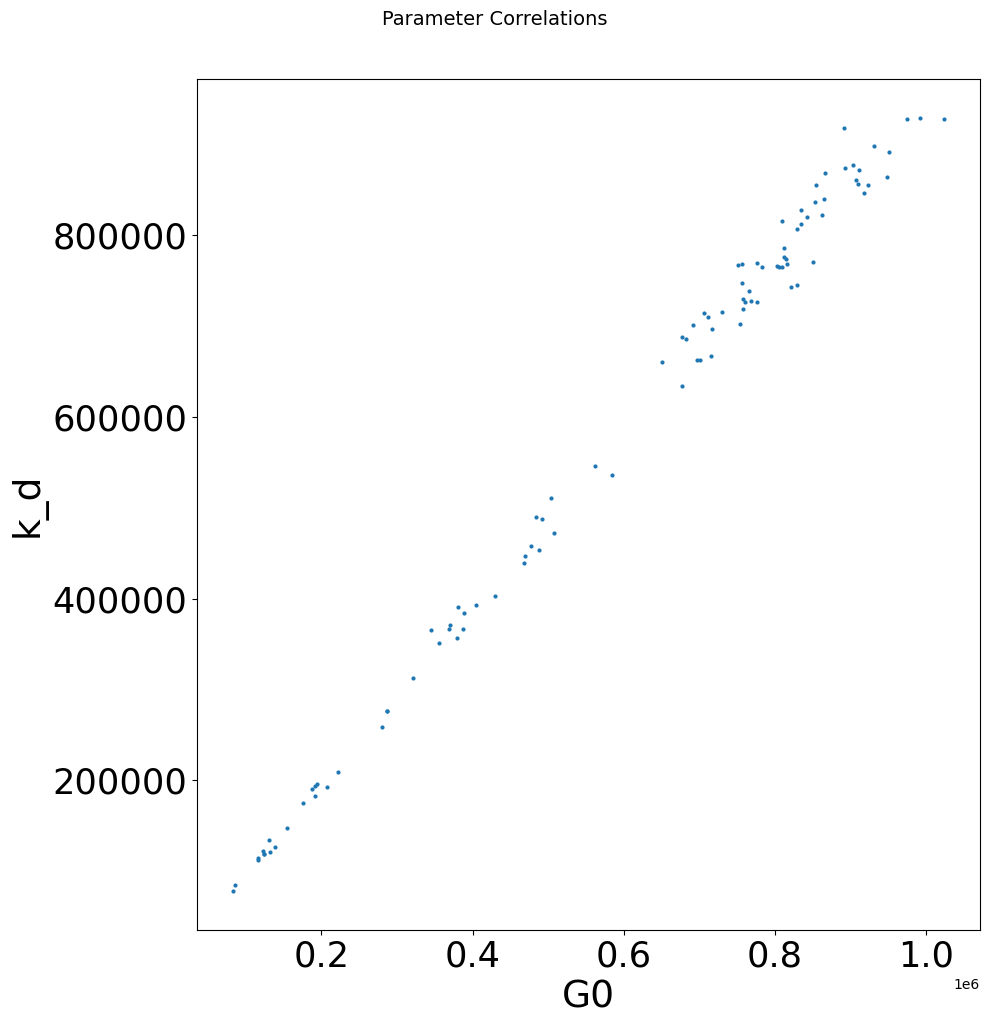

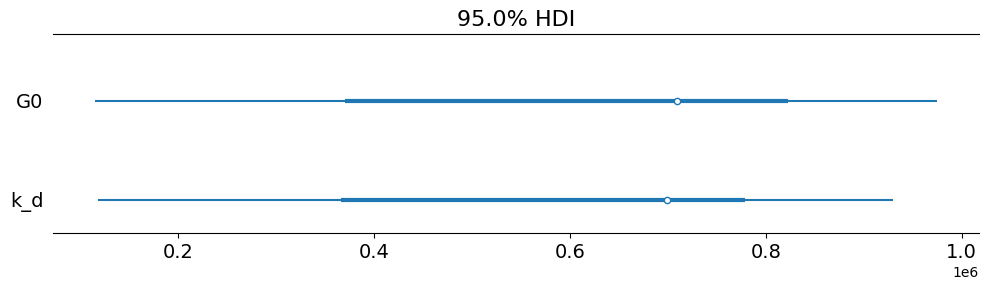

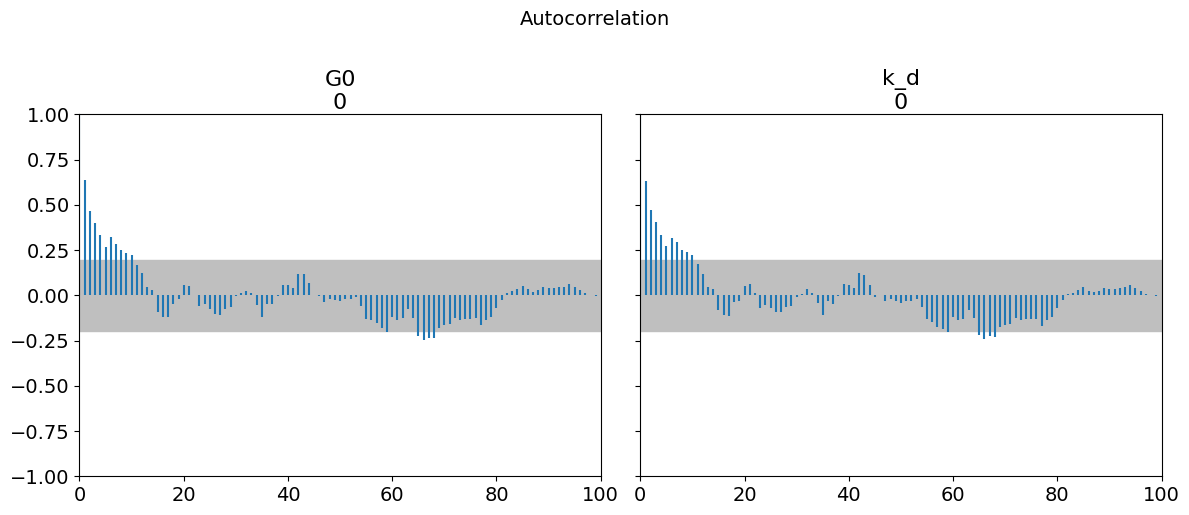

In [8]:
display_arviz_diagnostics(result, param_names, fast_mode=os.environ.get("FAST_MODE", "1") == "1")

## 6. Posterior Summary

In [9]:
posterior = result.posterior_samples
nlsq_vals = {"G0": model.G0, "k_d": model.k_d}
print_parameter_table(["G0", "k_d"], nlsq_vals, posterior)

Parameter Comparison
   Param        NLSQ  Bayes (median)                95% CI
----------------------------------------------------------
      G0        4.19       7.089e+05  [1.16e+05, 9.631e+05]
     k_d       2.326       6.994e+05  [1.134e+05, 9.232e+05]


## 7. Posterior Predictive Check

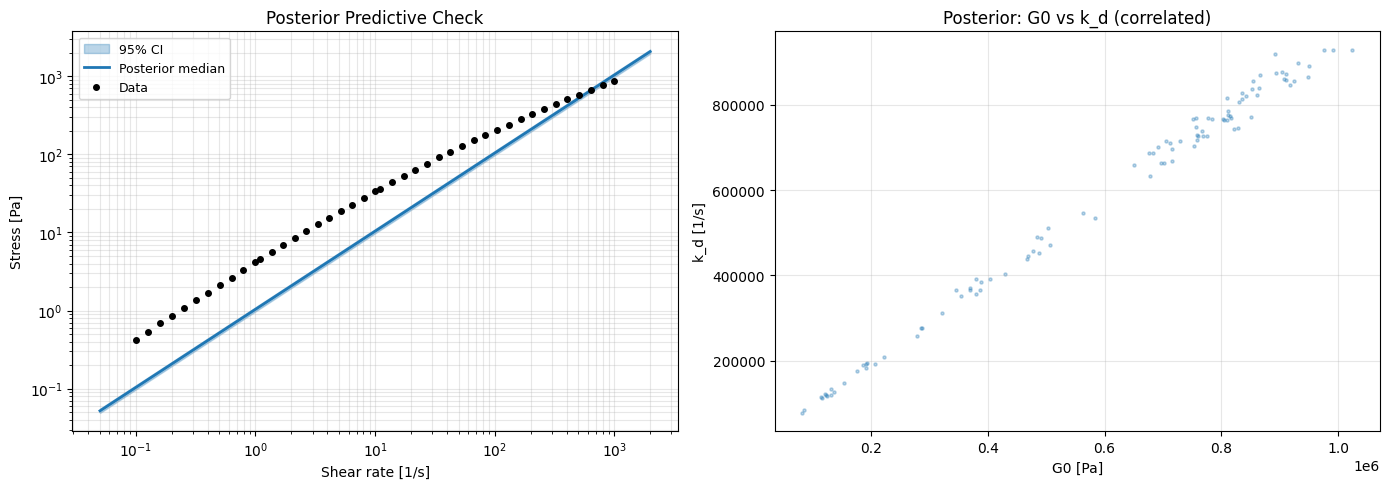

In [10]:
posterior = result.posterior_samples
n_draws = min(200, len(posterior['G0']))

stress_samples = []
for i in range(n_draws):
    model.parameters.set_value('G0', float(posterior['G0'][i]))
    model.parameters.set_value('k_d', float(posterior['k_d'][i]))
    stress_samples.append(np.array(
        model.predict(gamma_dot_fine, test_mode='flow_curve')
    ))

stress_arr = np.array(stress_samples)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Stress PPC
ax1.fill_between(gamma_dot_fine,
    np.percentile(stress_arr, 2.5, axis=0),
    np.percentile(stress_arr, 97.5, axis=0),
    alpha=0.3, color='C0', label='95% CI')
ax1.loglog(gamma_dot_fine, np.median(stress_arr, axis=0),
           'C0-', lw=2, label='Posterior median')
ax1.loglog(gamma_dot, stress, 'ko', markersize=4, label='Data')
ax1.set_xlabel('Shear rate [1/s]')
ax1.set_ylabel('Stress [Pa]')
ax1.set_title('Posterior Predictive Check')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3, which='both')

# Parameter correlation
ax2.scatter(np.array(posterior['G0'])[:n_draws],
            np.array(posterior['k_d'])[:n_draws],
            alpha=0.3, s=5)
ax2.set_xlabel('G0 [Pa]')
ax2.set_ylabel('k_d [1/s]')
ax2.set_title('Posterior: G0 vs k_d (correlated)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

In [11]:
# Derived quantity: eta_0 = G0/k_d (well-determined even though G0, k_d are not)
eta_samples = np.array(posterior['G0']) / np.array(posterior['k_d'])
print(f'eta_0 posterior: {np.median(eta_samples):.3f} '
      f'[{np.percentile(eta_samples, 2.5):.3f}, '
      f'{np.percentile(eta_samples, 97.5):.3f}] Pa*s')
print(f'eta_0 from data (mean viscosity): {np.mean(viscosity):.3f} Pa*s')

eta_0 posterior: 1.038 [0.975, 1.103] Pa*s
eta_0 from data (mean viscosity): 3.043 Pa*s


## 8. Save Results

In [12]:
output_dir = get_output_dir("flow_curve")
save_results(output_dir, model, result, ["G0", "k_d"], None)
print("Done.")

Saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/vlb/flow_curve/
Done.


## Key Takeaways

1. **VLB flow curve is Newtonian** — only $\eta_0 = G_0/k_d$ is determined
2. **Individual G₀, k_d are not identifiable** from flow curve data alone
3. **Posterior correlation** is expected and physically meaningful
4. **Shear-thinning residuals** motivate the Bell force-extension (Notebook 08)
5. **SAOS data** (Notebook 15) is the best protocol for identifying both parameters

## Next

- **Notebook 12**: Creep compliance NLSQ → NUTS